This is a minimal example showing 2 methods of generating GHZ state on IBM device based on the blogpost: 

In [2]:
# Importing all the parts we need
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

# Preparing registers
quantum_register = QuantumRegister(127, name='q')
classical_register = ClassicalRegister(127, name='c')

# For simplicity we map the physical qubits to the logical qubits directly using the same number.
initial_layout = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
    124,
    125,
    126,
]
# The "even"" qubits will be used for the 54 qubit GHZ-state
ghz_qubits = [
    0,
    2,
    4,
    6,
    8,
    10,
    12,
    18,
    20,
    22,
    24,
    26,
    28,
    30,
    32,
    37,
    39,
    41,
    43,
    45,
    47,
    49,
    51,
    56,
    58,
    60,
    62,
    64,
    66,
    68,
    70,
    75,
    77,
    79,
    81,
    83,
    85,
    87,
    89,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    114,
    116,
    118,
    120,
    122,
    124,
    126,
]
# The "odd" qubits will be used as the stabilizers
stabilizer_qubits = [
    1,
    3,
    5,
    7,
    9,
    11,
    14,
    15,
    16,
    17,
    19,
    21,
    23,
    25,
    27,
    29,
    31,
    33,
    34,
    35,
    36,
    38,
    40,
    42,
    44,
    46,
    48,
    50,
    52,
    53,
    54,
    55,
    57,
    59,
    61,
    63,
    65,
    67,
    69,
    71,
    72,
    73,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    91,
    92,
    93,
    95,
    97,
    99,
    101,
    103,
    105,
    107,
    109,
    110,
    111,
    112,
    115,
    117,
    119,
    121,
    123,
    125,
]

## BFS Method

We start by importing a 'Fake' backend, and look at the coupling map

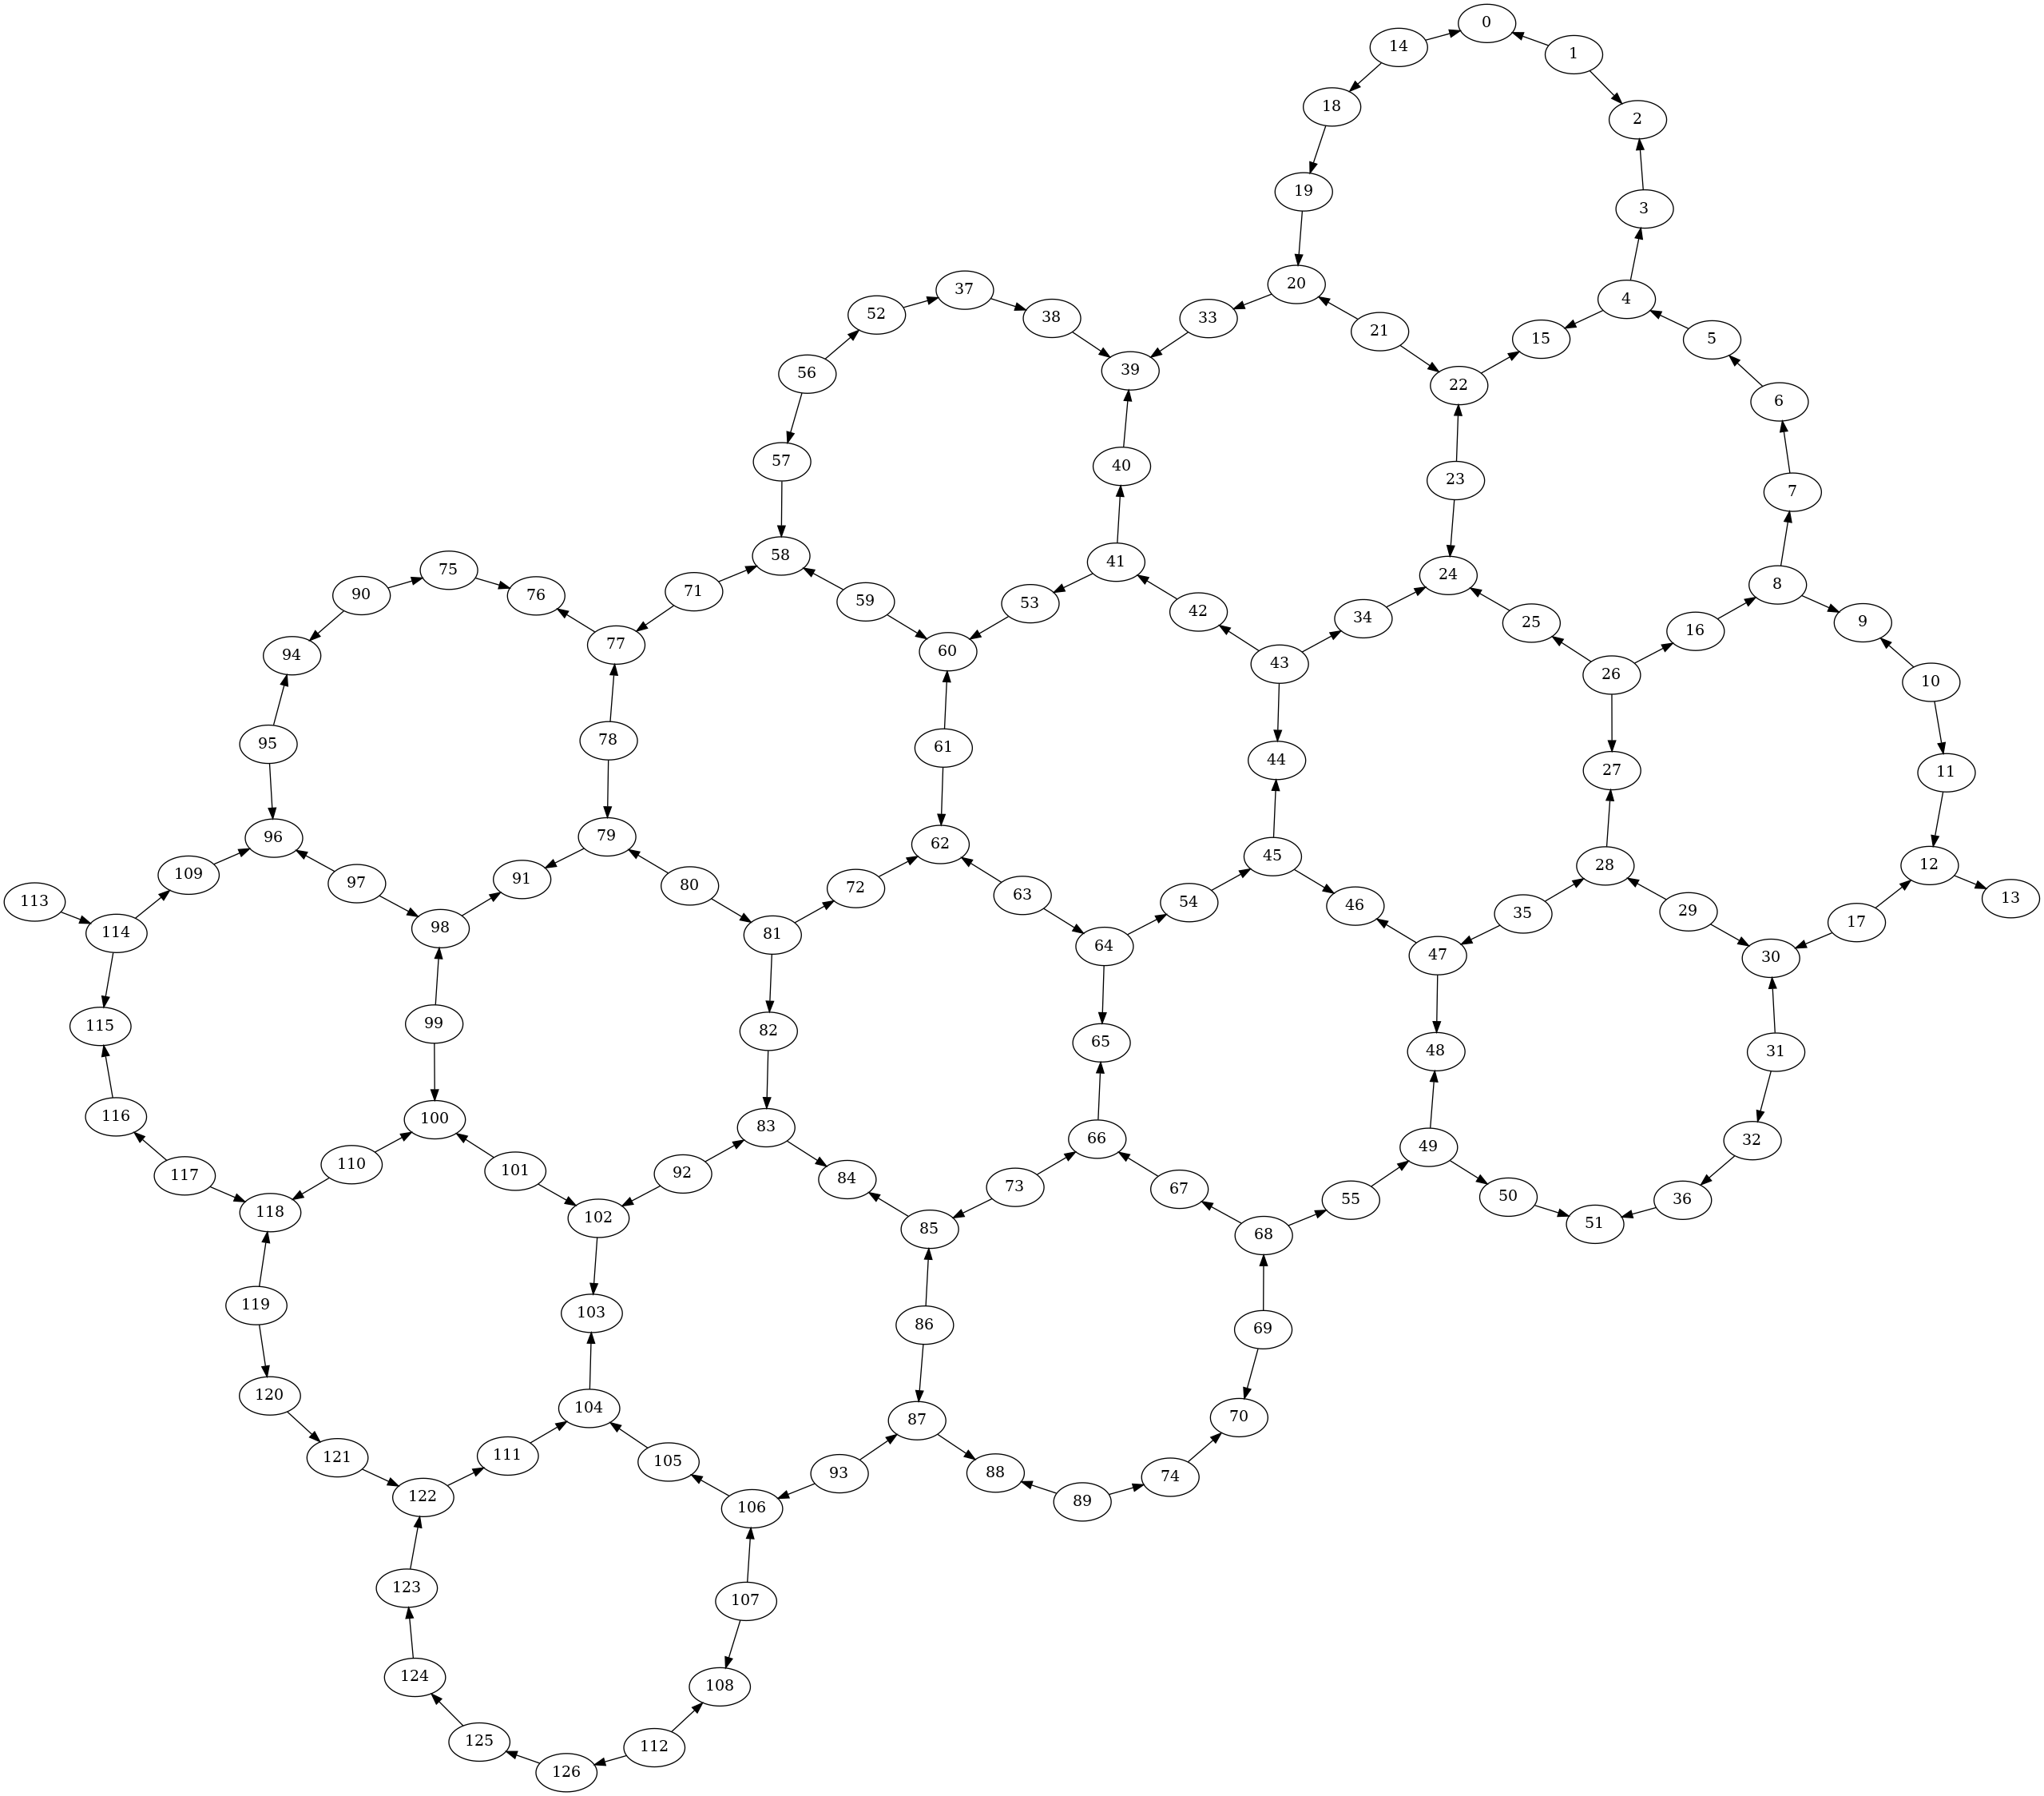

In [24]:
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.visualization import plot_gate_map, plot_error_map

backend = FakeSherbrooke()
backend.coupling_map.draw()

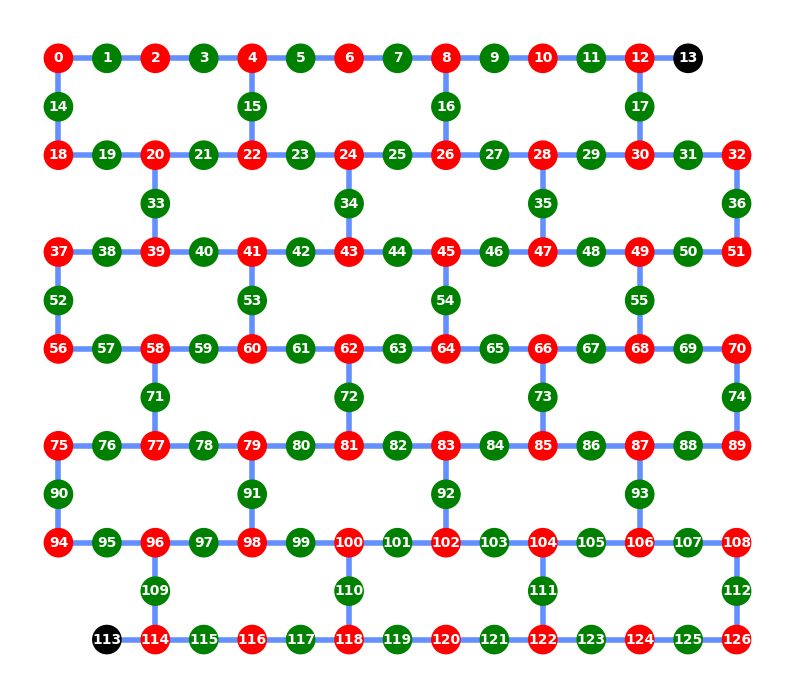

In [25]:
qubit_color = []
for i in range(127):
    if i in ghz_qubits:
        qubit_color.append("r")
    elif i in stabilizer_qubits:
        qubit_color.append("g")
    else:
        qubit_color.append('k')
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=10, font_size=30, figsize=(10, 10))

Import as rustworkx undirected graph and remove the additional qubits 13 and 113

In [27]:
import rustworkx as rx

g = backend.coupling_map.graph.copy().to_undirected()
g.remove_node(13)
g.remove_node(113)

Look at the betweenness centrality to choose a good starting point for BFS

In [28]:
c_degree = dict(rx.betweenness_centrality(g))
# c_degree = nx.closeness_centrality(g.reverse(), distance='weight')
central = max(c_degree, key=c_degree.get)
central

62

Visualize the betweenness centrality on the graph

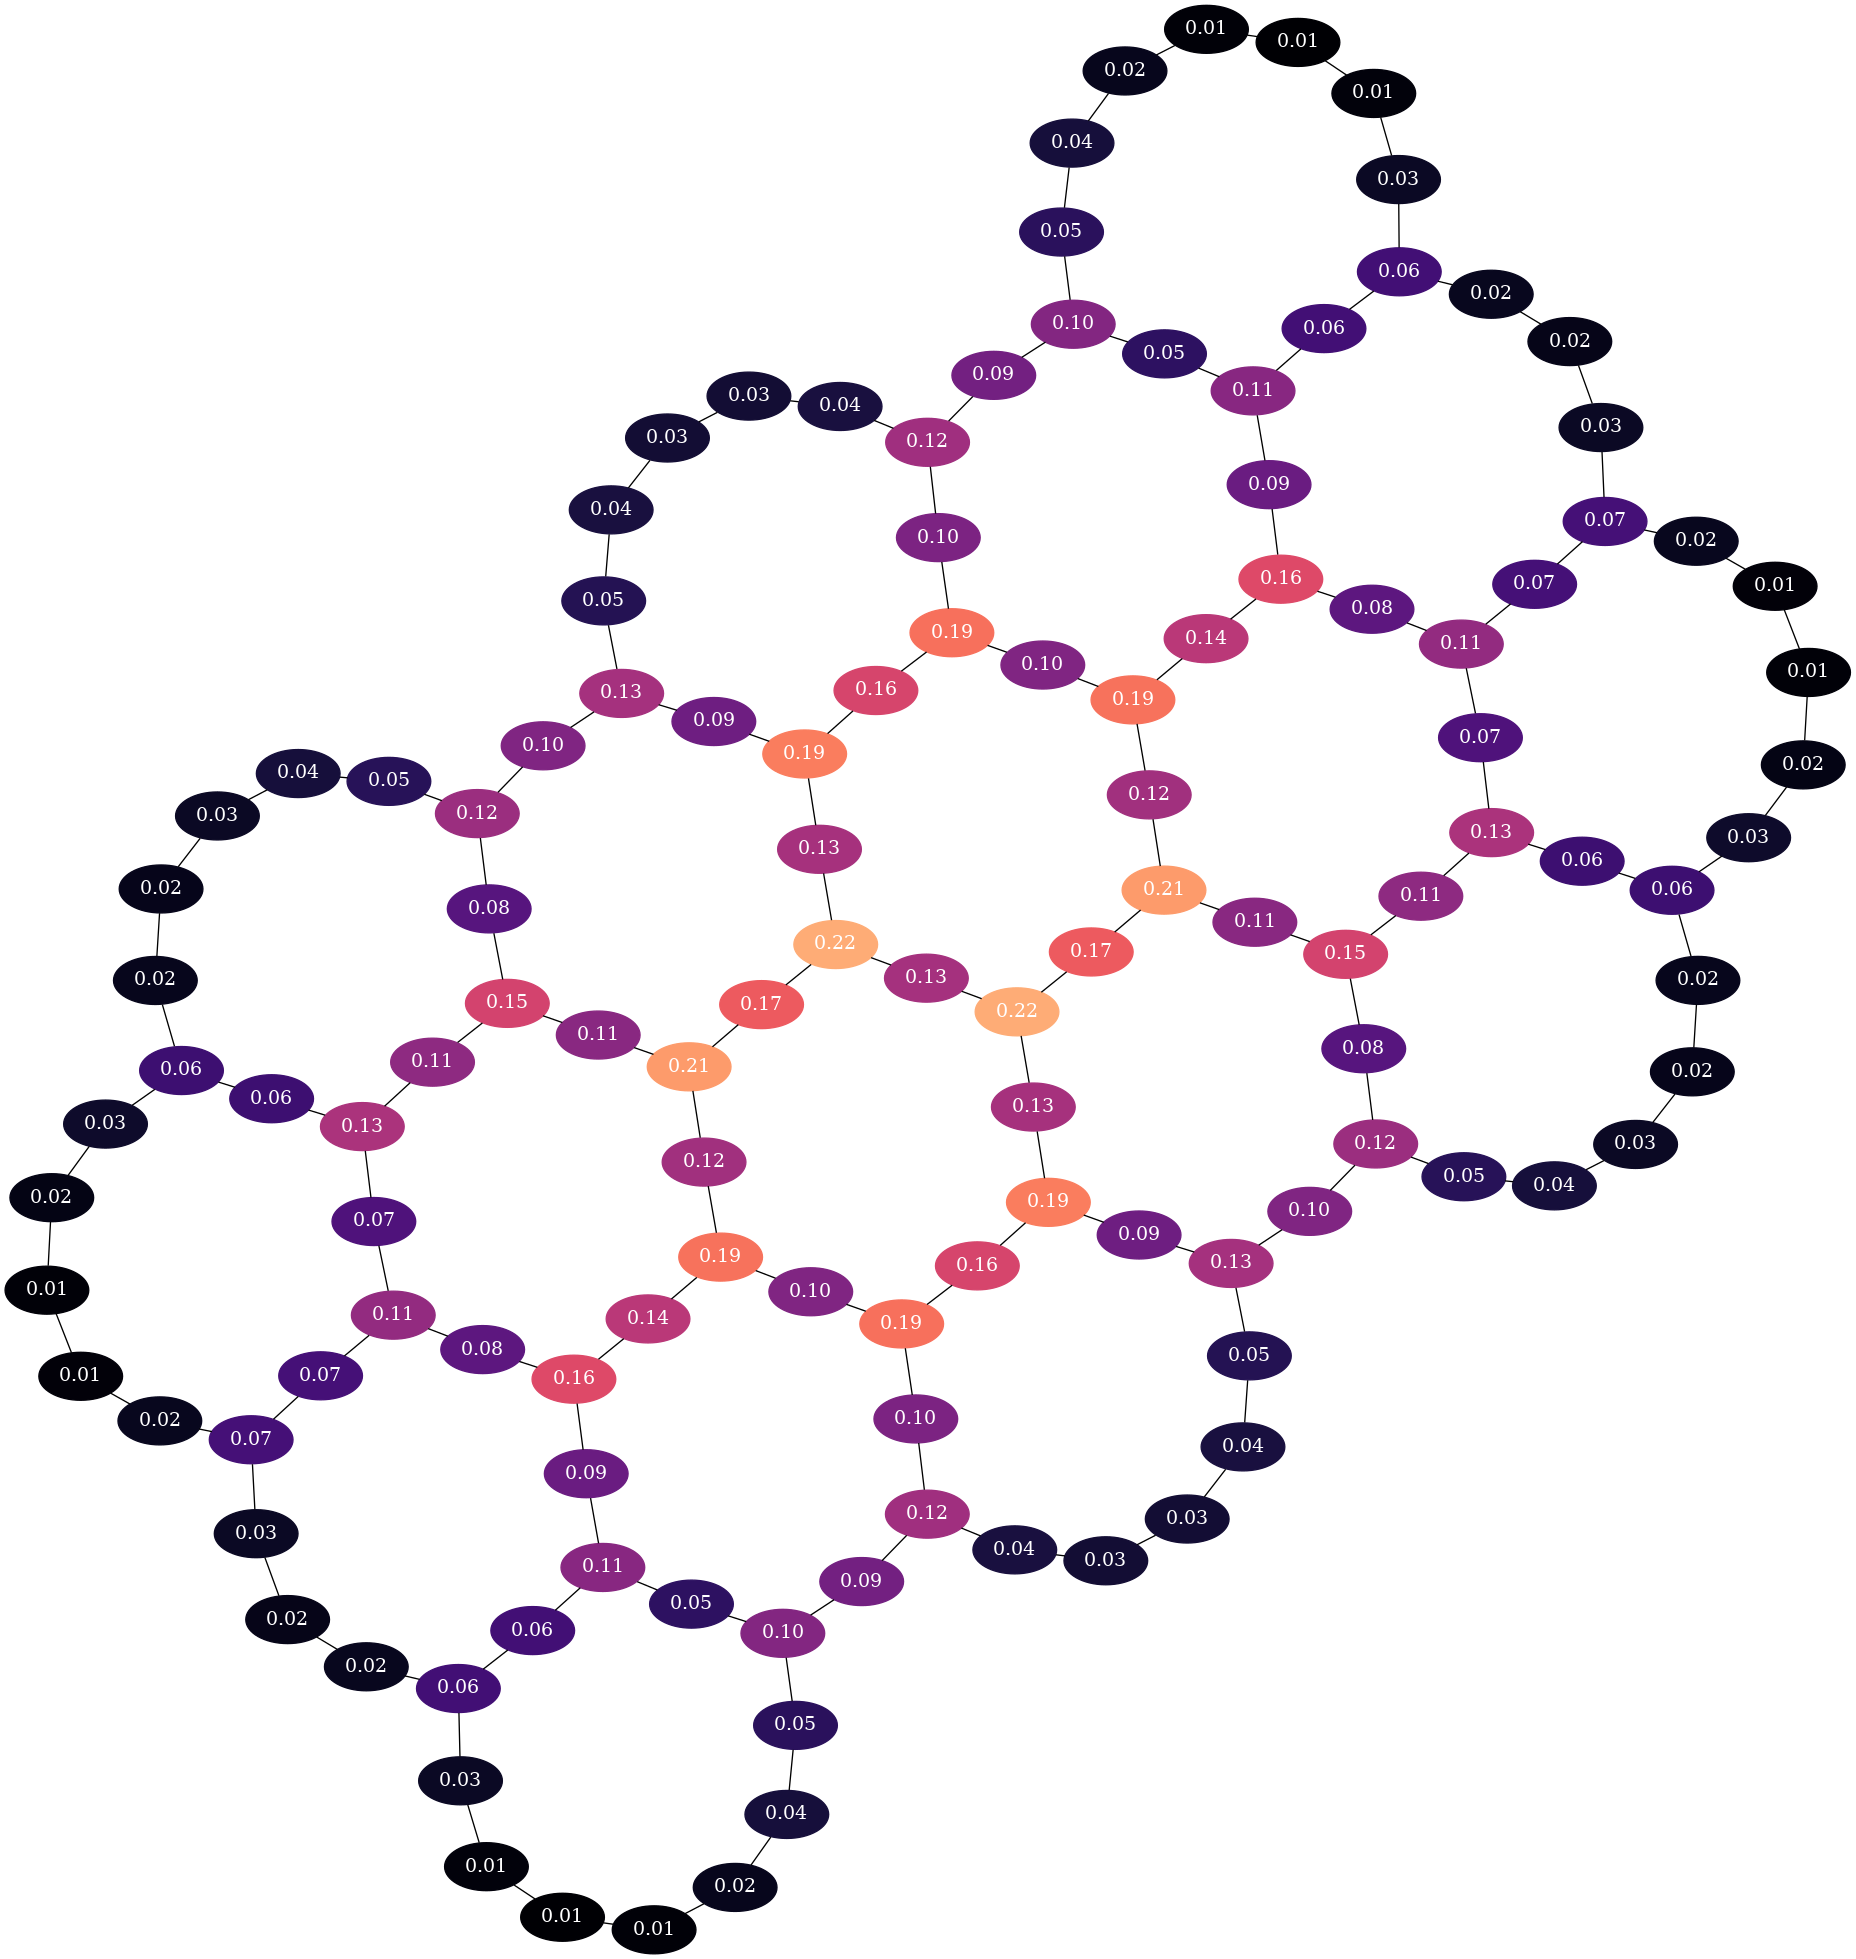

In [29]:
from rustworkx.visualization import graphviz_draw
import matplotlib

# For graphviz visualization we need to assign the data payload for each
# node to its centrality value so that we can color based on this
for node, btw in c_degree.items():
    g[node] = btw

# Leverage matplotlib for color map
colormap = matplotlib.colormaps["magma"]
norm = matplotlib.colors.Normalize(
    vmin=min(c_degree.values()),
    vmax=max(c_degree.values())*1.2
)

def color_node(node):
    rgba = matplotlib.colors.to_hex(colormap(norm(node)), keep_alpha=True)
    return {
        "color": f"\"{rgba}\"",
        "fillcolor": f"\"{rgba}\"",
        "style": "filled",
        "fontcolor": "white",
        # "shape": "circle",
        "label": "%.2f" % node,
    }

graphviz_draw(g, node_attr_fn=color_node, method="neato", graph_attr={'scale': '0.8'})

Generate a BFS tree from the root node

In [30]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self):
        self.edges = []

    def tree_edge(self, edge):
        self.edges.append(edge)

vis = TreeEdgesRecorder()
rx.bfs_search(g, [central], vis)
print('Tree edges:', vis.edges)

Tree edges: [(62, 63, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.007967309217199875, calibration=PulseQobj)}), (62, 72, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.004062901822998344, calibration=PulseQobj)}), (62, 61, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.008411347102088296, calibration=PulseQobj)}), (63, 64, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.007610686805367195, calibration=PulseQobj)}), (72, 81, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.009457433485927369, calibration=PulseQobj)}), (61, 60, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.01356355965011638, calibration=PulseQobj)}), (64, 65, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.0058749821168687655, calibration=PulseQobj)}), (64, 54, {'ecr': InstructionProperties(duration=5.333333333333332e-07, error=0.009295171043138095, calibration=P

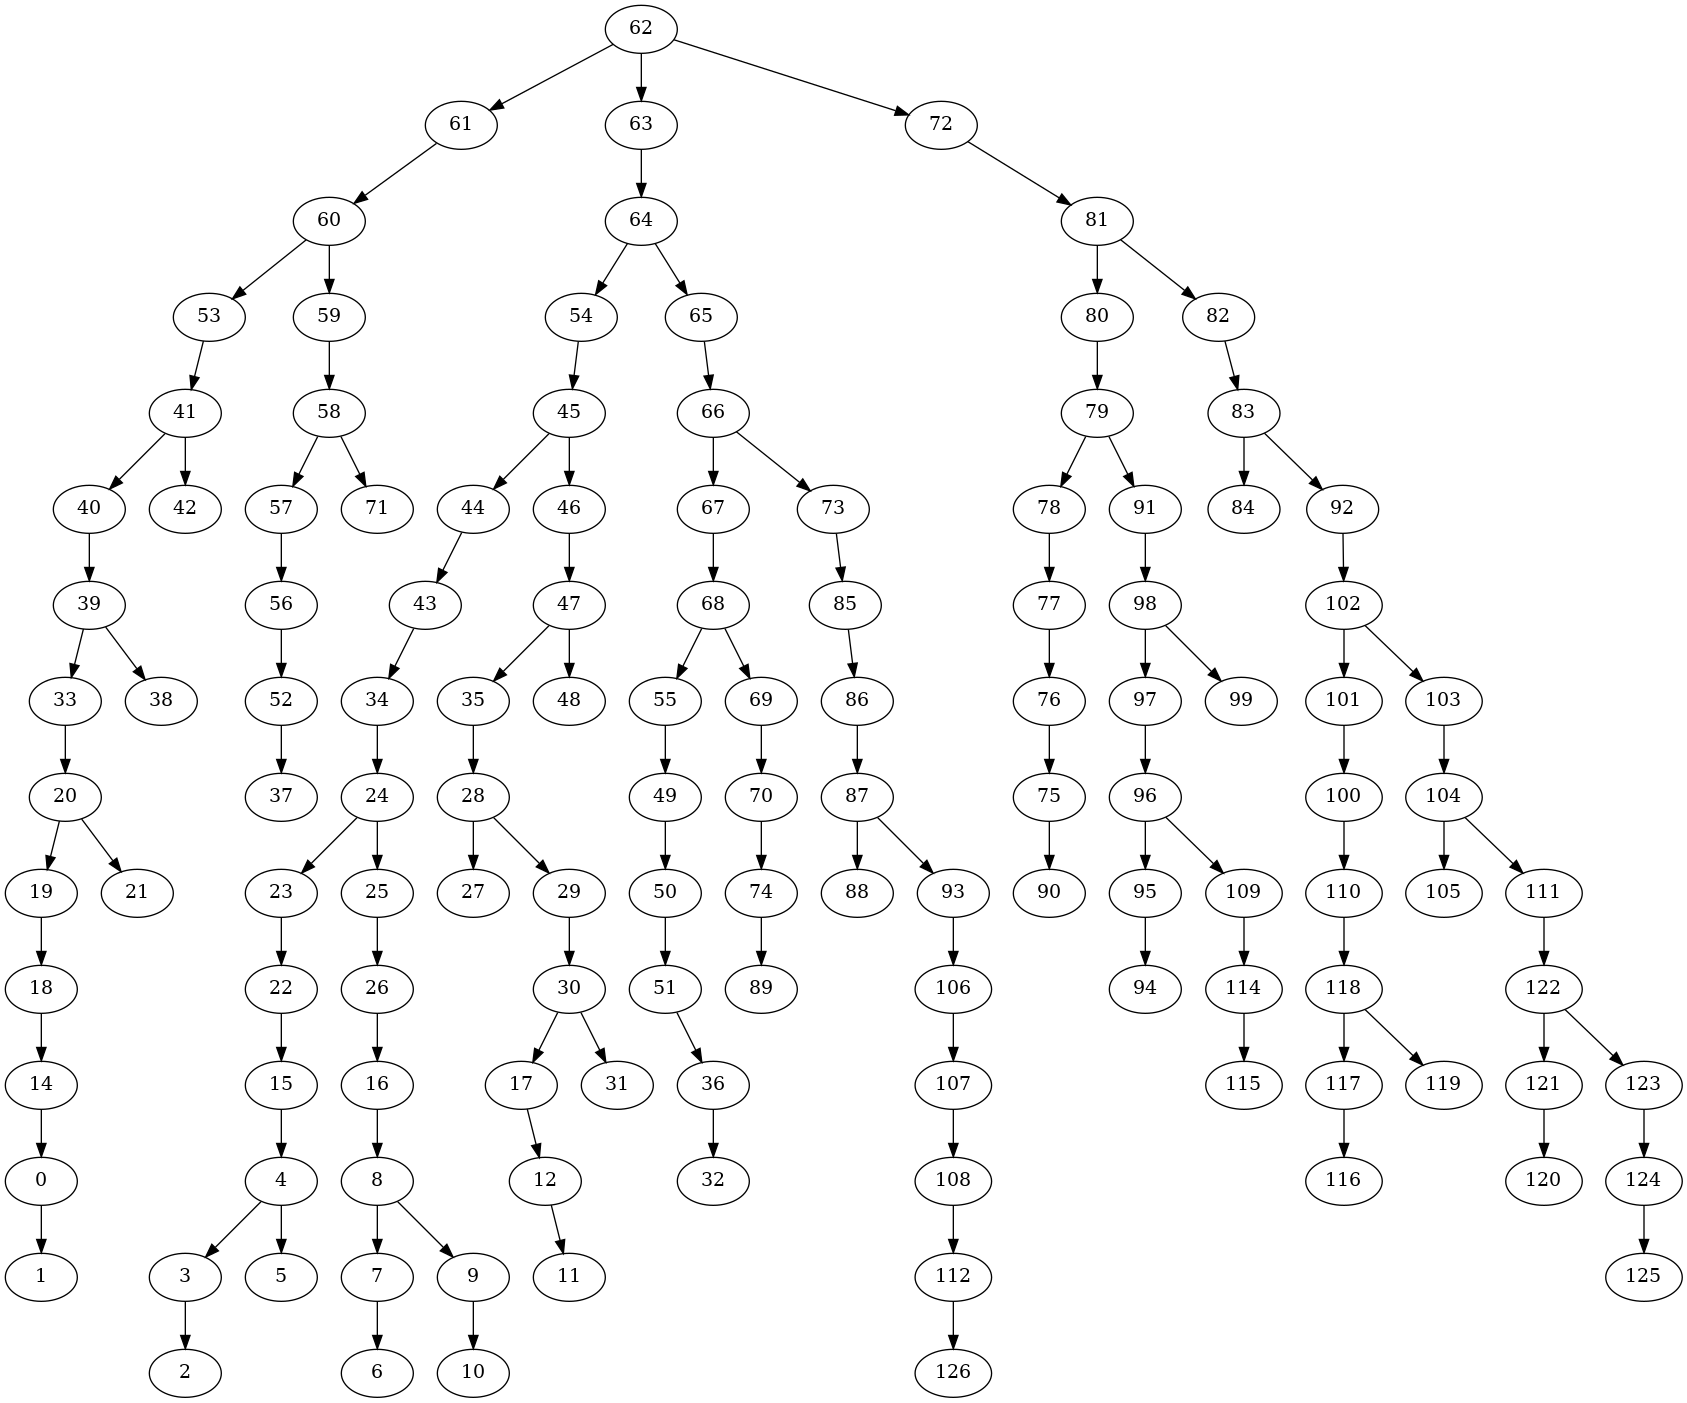

In [32]:
t = rx.PyDiGraph()
t.extend_from_weighted_edge_list(vis.edges)
t.remove_node(13)
t.remove_node(113)

graphviz_draw(t, method='dot')

Rearranging the order of the edges to minimize depth

In [33]:
mapping = rx.bellman_ford_shortest_paths(t, central)
sorted_target = []
path_length = []
for target, path in mapping.items():
    sorted_target.append(target)
    path_length.append(len(path))

# get sorted target from path length
sorted_target = [x for _, x in 
                 sorted(zip(path_length, sorted_target), 
                        reverse=True)]

new_t = rx.PyDiGraph(multigraph=False)
new_t.add_nodes_from(range(127))
for target in sorted_target:
    for i in range(len(mapping[target])-1):
        # data is not needed for tree
        new_t.add_edge(mapping[target][i], mapping[target][i+1], None)
new_t.remove_node(13)
new_t.remove_node(113)

Generate and obtain the circuit depth required for entangling the whole device

In [41]:
def generate_ghz127():
    qc = QuantumCircuit(quantum_register, classical_register)

    tree = new_t
    qc.h(tree.edge_list()[0][0])
    # tranverse the bfs tree and perform cnot on each edge starting from the root
    for u, v in tree.edge_list():
        qc.cx(u, v)

    return qc


ghz_circuit = generate_ghz127()
print('Depth:', ghz_circuit.depth())
ghz_circuit.measure_all(add_bits=False)

Depth: 17


In [42]:
ghz_circuit_transpile = transpile(ghz_circuit, backend, initial_layout=initial_layout)
print('Depth:', ghz_circuit_transpile.depth())

Depth: 48


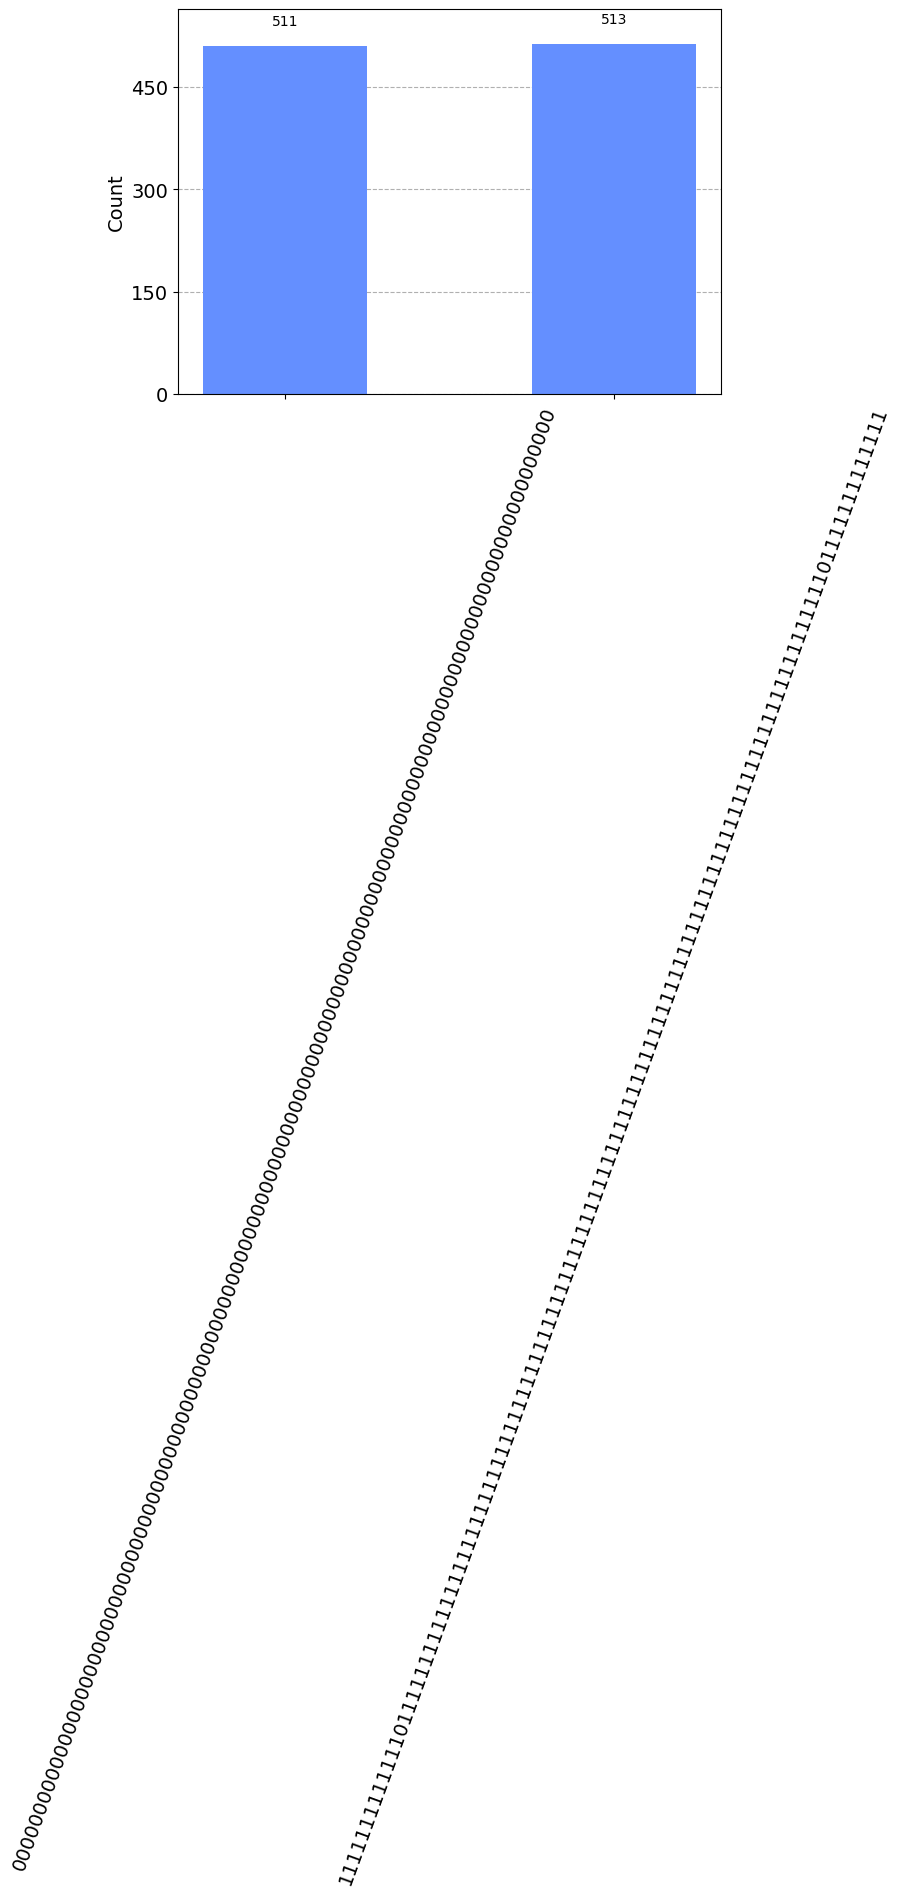

In [37]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

# We first choose a simulator as our backend without any noise
aer = Aer.get_backend("aer_simulator")
# We run the simulation and get the counts
counts = aer.run(ghz_circuit, shots=1024).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

## Dynamic Circuit
We begin by looking at a simple circuit to generate a GHZ state with feedback, expressed explicitly with `c_if`

Depth: 13


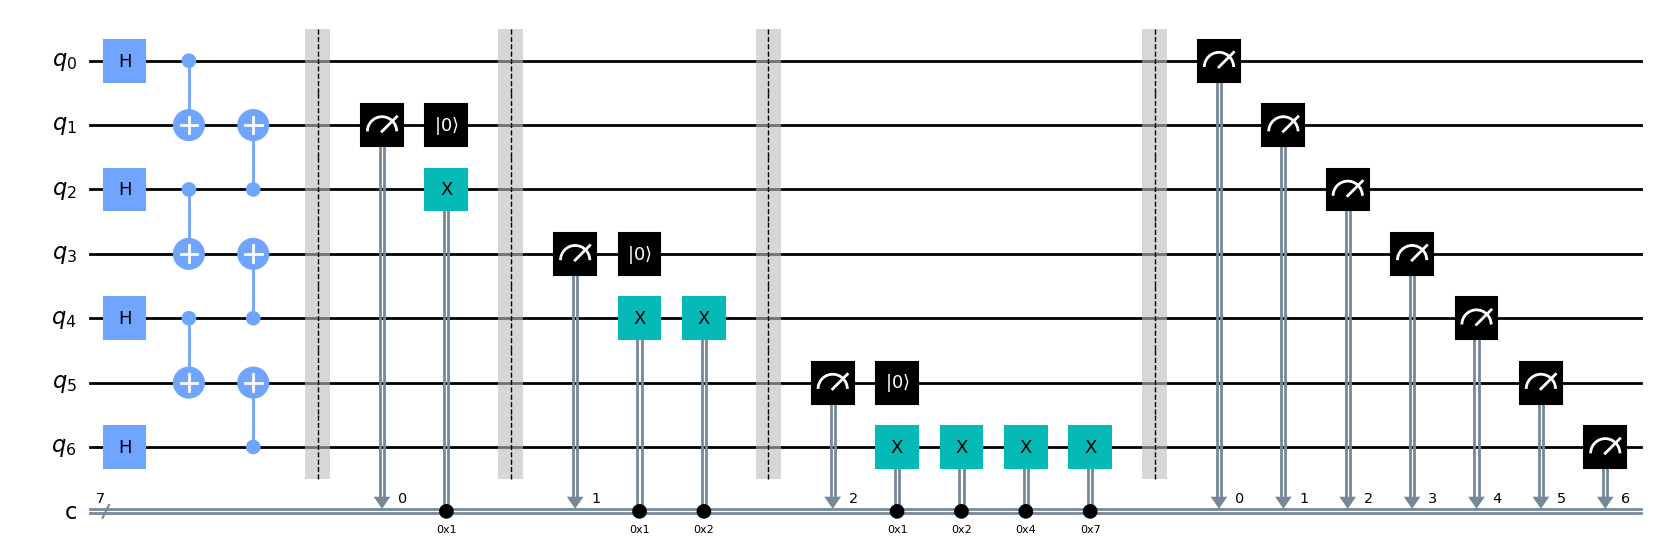

In [59]:
qubits_num = 7
qr = QuantumRegister(qubits_num, 'q')
cr = ClassicalRegister(qubits_num, 'c')

qc = QuantumCircuit(qr, cr)

ent_qubits = [i for i in range(qubits_num) if i % 2 == 0]
meas_qubits = [i for i in range(qubits_num) if i % 2 != 0]

# hadamard
qc.h(ent_qubits)
# first layer cnot
qc.cx(ent_qubits[:-1], meas_qubits)
# second layer cnot
qc.cx(ent_qubits[1:], meas_qubits)
# measurement and X gate
qc.barrier()
qc.measure(1, 0)
qc.reset(1)
qc.x(2).c_if(cr, 1)
qc.barrier()
qc.measure(3, 1)
qc.reset(3)
qc.x(4).c_if(cr, 1)
qc.x(4).c_if(cr, 2)
qc.barrier()
qc.measure(5, 2)
qc.reset(5)
qc.x(6).c_if(cr, int(b'001', 2))
qc.x(6).c_if(cr, int(b'010', 2))
qc.x(6).c_if(cr, int(b'100', 2))
qc.x(6).c_if(cr, int(b'111', 2))

print('Depth:', qc.depth())

# measurement
qc.measure_all(add_bits=False)

qc.draw(idle_wires=False, output='mpl')

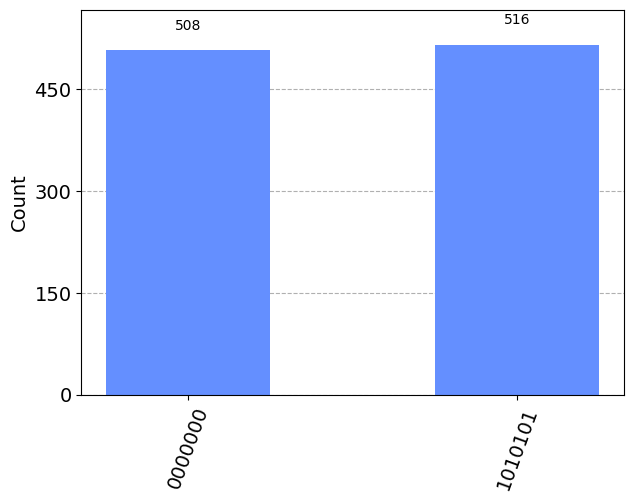

In [60]:
counts = aer.run(qc, shots=1024).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

with `if_test`

Depth: 7


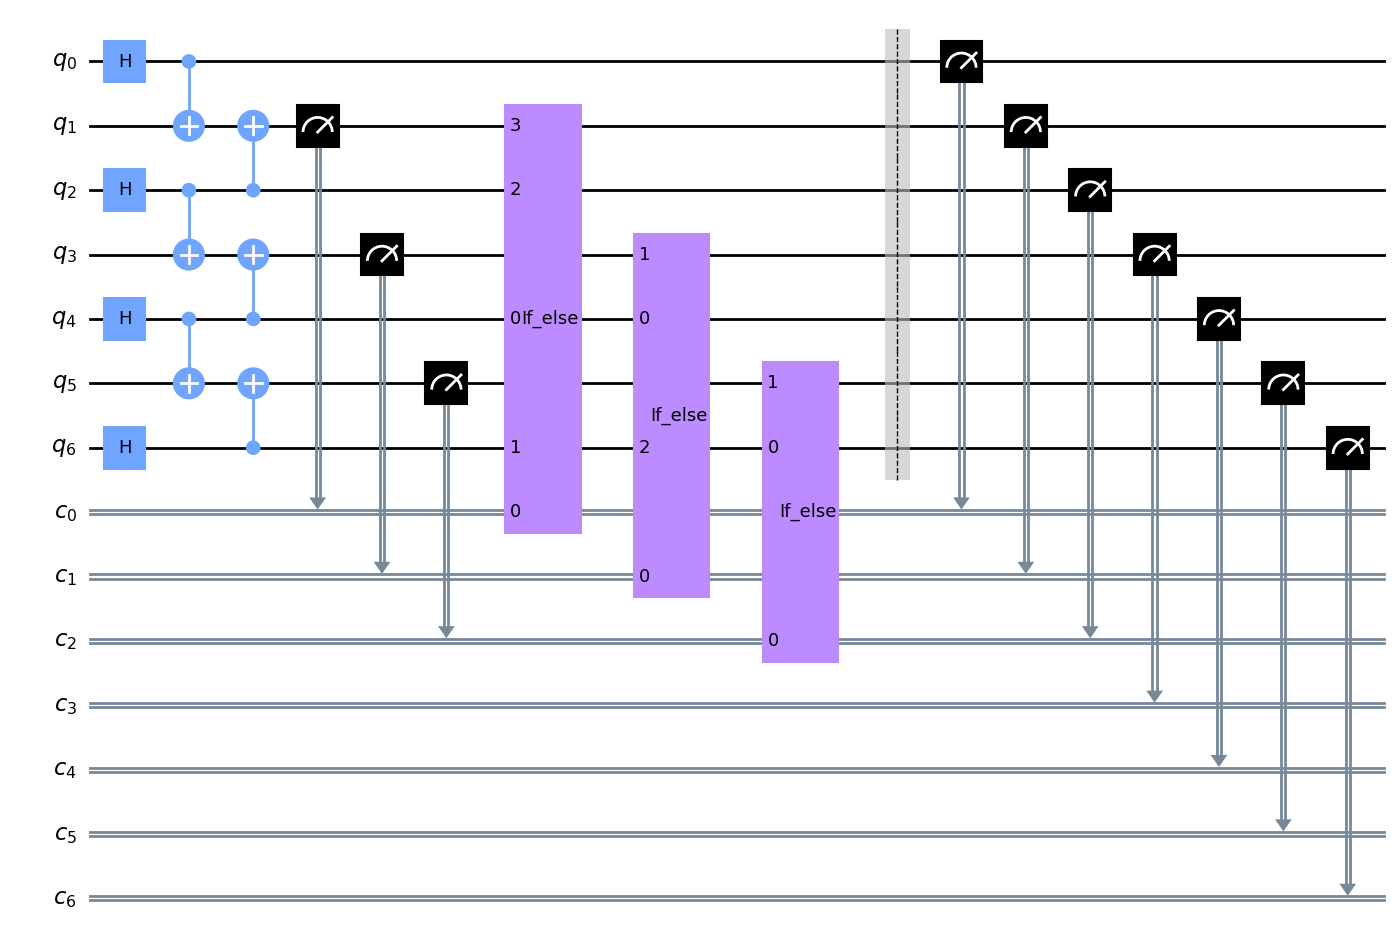

In [48]:
qc.clear()

ent_qubits = [i for i in range(qubits_num) if i % 2 == 0]
meas_qubits = [i for i in range(qubits_num) if i % 2 != 0]

# hadamard
qc.h(ent_qubits)
# first layer cnot
qc.cx(ent_qubits[:-1], meas_qubits)
# second layer cnot
qc.cx(ent_qubits[1:], meas_qubits)
# measurement
for i, q in enumerate(meas_qubits):
    qc.measure(q, i)

ent_qc = qc.copy()

# X gate
for i, c in enumerate(meas_qubits):
    with qc.if_test((i, 1)) as else_:
        qc.x(ent_qubits[i+1:])
        qc.x(c)
    
print('Depth:', qc.depth())

# measurement
qc.measure_all(add_bits=False)

qc.draw(idle_wires=False, output='mpl')

with `switch_case`

Depth: 5


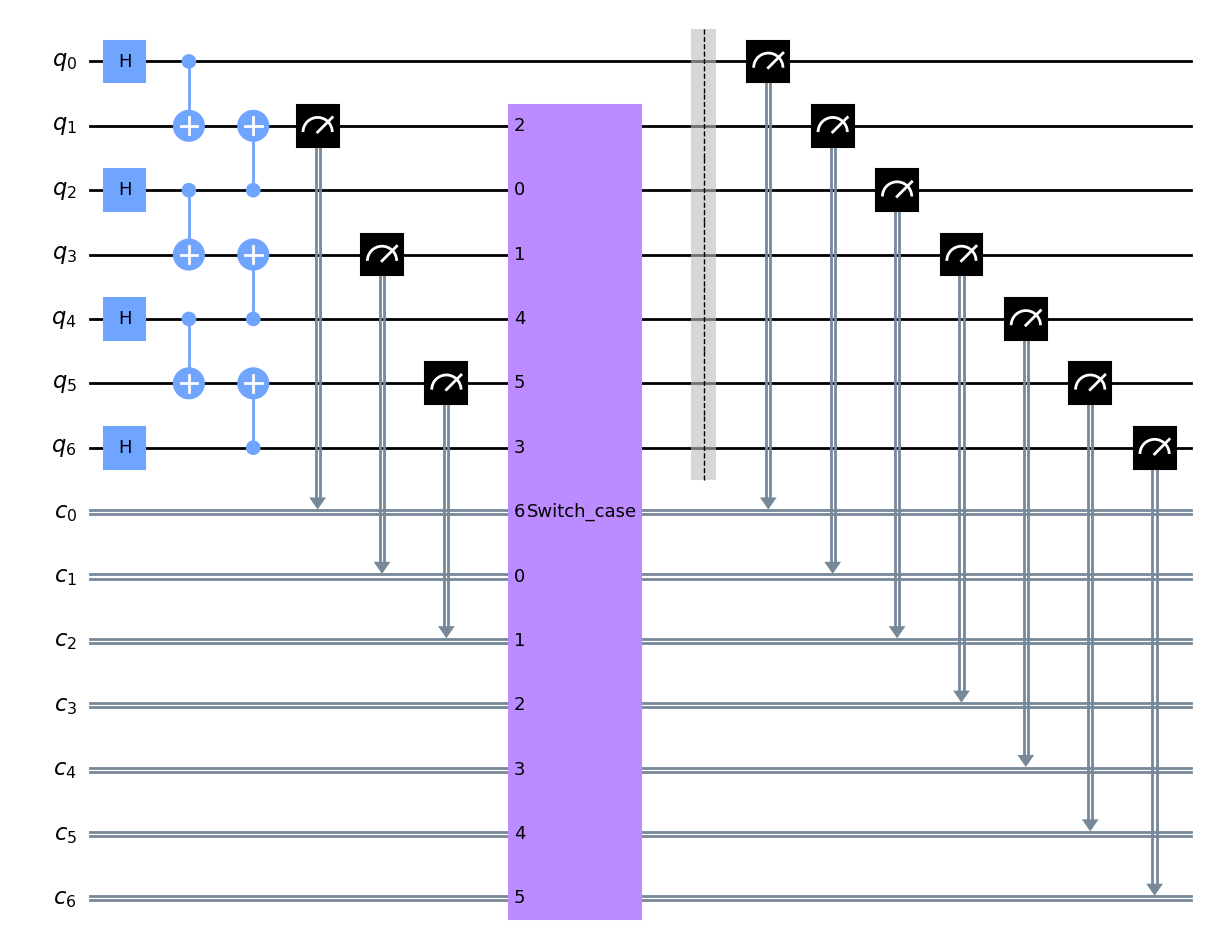

In [50]:
import itertools

qc = ent_qc.copy()

bin_str_list = []
x_gate_list = []
for bin_str in itertools.product([0, 1], repeat=len(meas_qubits)):
    bin_str_list.append(int(''.join(map(str, bin_str[::-1])), 2))
    parity = 0
    x_gate_list.append([])
    for i in range(len(bin_str)):
        parity = (parity + bin_str[i]) % 2
        if parity == 1:
            x_gate_list[-1].append(ent_qubits[i+1])
        if bin_str[i] == 1:
            x_gate_list[-1].append(meas_qubits[i])

with qc.switch(cr) as case:
    for bin_str, x_gate in zip(bin_str_list, x_gate_list):
        with case(bin_str):
            for x in x_gate:
                qc.x(x)
    
print('Depth:', qc.depth())

# measurement
qc.measure_all(add_bits=False)

qc.draw(idle_wires=False, output='mpl')

To apply this to a circuit to IBM hardware with Hex layout, we use chain decomposition

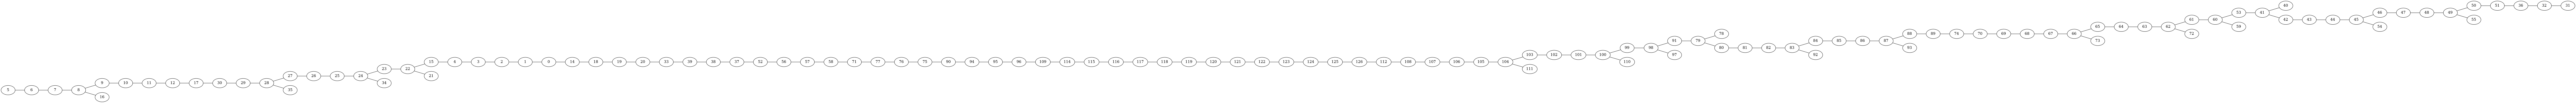

In [57]:
import numpy as np

# https://arxiv.org/abs/1209.0700
chain = rx.chain_decomposition(g, 10)
r = rx.PyGraph()

sep_chain_len = [len(el) for el in chain[1:]]
longest_sep_chain_idx = np.argmax(sep_chain_len)
longest_sep_chain = chain[1+longest_sep_chain_idx]

# first cycle remained close because there is no 
# guaranteed that the source yields the longest chain
_chain = [(e[0], e[1], 1) for e in chain[0]]
r.extend_from_weighted_edge_list(_chain)
# r.extend_from_edge_list(chain[0])
for i, el in enumerate(chain[1:]):
    # the other cycle is expressed as spoke of the first
    # cycle
    if i == longest_sep_chain_idx:
        _chain = [(e[0], e[1], 1) for e in el[:-1]]
        r.extend_from_weighted_edge_list(_chain)
    else:
        _chain = [(e[0], e[1], 2) for e in el[:-1]]
        r.extend_from_weighted_edge_list(_chain)
root, spoke = longest_sep_chain[0]
for n in r.neighbors(root):
    if n != spoke:
        r.remove_edge(n, root)
        break
r.remove_node(13)
r.remove_node(113)

graphviz_draw(r, graph_attr={'rankdir': 'LR'})

The circuit can then be implemented the main chain of the graph and the branches are coupled via additional CNOTs as per the usual treatment. This is left as an exercise to the reader.